# Deskripsi



1.   Formulasi Masalah

  Bagaimana mengelompokkan spesies ikan berdasarkan karakteristik morfometrik (panjang, berat, dan rasio W/L) untuk mengidentifikasi pola pertumbuhan dan klasifikasi alami spesies ikan di Sungai Tetulia, Bangladesh Selatan?

2.  Tujuan Clustering
  
  *   Konservasi: Mengelompokkan spesies berdasarkan kebutuhan habitat yang serupa

  *   Akuakultur: Mengidentifikasi spesies dengan potensi pertumbuhan ekonomis
  *   Ekologi: Memahami niche morfometrik spesies ikan di ekosistem sungai
  * Taksonomi: Mendukung klasifikasi spesies berdasarkan karakteristik morfometrik






# Import Library

In [65]:
import pandas as pd # load & preprocess data
import matplotlib.pyplot as plt # visualisasi
import seaborn as sns # visualisasi
import warnings
warnings.filterwarnings('ignore')
import numpy as np

# exploration & load data

# Fungsi Load Data

In [66]:
# def load_data(file_path):
#   df = pd.read_csv(file_path) # load data

#   ## preprocessing
#   df = df.drop_duplicates()
#   df.duplicated().sum()

#   return df

# # load data

# df = load_data("/content/drive/MyDrive/Tubes Machine Learning/fish_data.csv")
# df


# Standard Scaler

In [67]:
class StandardScaler:
  def __init__(self) :
    self.mean = None
    self.std = None

  def fit(self, X): # berfungsi menghitung rata-rata dan standar deviasi
    self.mean = np.mean(X, axis=0)
    self.std = np.std(X, axis=0)
    return self # Add this line to return the instance

  def transform(self, X): # transform data ke bentuk standarisasi
    return (X - self.mean) / self.std

  def fit_transform(self, X): # fit dan transform data
    return self.fit(X).transform(X)

  def inverse_transform(self, X): # transform kembali ke skala original
    return X * self.std + self.mean

# Principal Component analysis (PCA)

In [68]:
class PCA:
  def __init__(self, n_components):
    self.n_components = n_components
    self.components = None
    self.explained_variance = None
    self.explained_variance_ratio = None

  def fit(self, X): # Fit PCA to Data
    self.mean = np.mean(X, axis=0)
    X_centered = X - self.mean

    cov_matrix = np.cov(X_centered, rowvar=False) #hitung matriks kovarians

    #hitung eigenvalues dan eigenvector
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    self.components = eigenvectors[:, :self.n_components]
    self.explained_variance = eigenvalues[:self.n_components]
    self.explained_variance_ratio = self.explained_variance / np.sum(eigenvalues)

    return self

  def transform(self, X): #Transform data ke bentuk PCA
    X_centered = X - self.mean
    return np.dot(X_centered, self.components.T)

  def fit_transform(self, X):
    return self.fit(X).transform(X) # fit dan transform data


# Kmeans

In [89]:
class Kmeans:
  def __init__(self, k, max_iter=100, tol=1e-4, init='random'):
    self.k = k
    self.max_iter = max_iter
    self.tol = tol
    self.init = init


  def init_centroid(self, X):  # fungsi untuk inisialisasi centroid
    n_sample, n_fitur = X.shape

    if self.init == 'random':
        # inisialisasi random centroid
        centroid = np.random.uniform(X.min(axis=0), X.max(axis=0), (self.k, n_fitur))

    elif self.init == 'kmeans++':
        centroid = []  # inisialisasi kmeans+

        # menentukan centroid pertama secara random
        centroid.append(X[np.random.randint(n_sample)])

        for _ in range(1, self.k):
            # hitung jarak ke centroid terdekat
            distance = np.array([
                min([np.linalg.norm(x - c)**2 for c in centroid]) for x in X
            ])

            # tentukan centroid selanjutnya dengan probabilitas
            probability = distance / distance.sum()
            cumulative_prob = probability.cumsum()
            r = np.random.rand()

            for j, p in enumerate(cumulative_prob):
                if r < p:
                    centroid.append(X[j])
                    break

        # ubah list centroid jadi array numpy setelah loop selesai
        centroid = np.array(centroid)

    return centroid


  def euclidean_distance(self, point1, point2): #kalkulasi jarak euclid
    return np.sqrt(np.sum((point1 - point2) ** 2))

  def assign_clusters(self, X, centroid): #assign point ke centroid terdekat
    n_sample = X.shape[0]
    clusters = np.zeros(n_sample)

    for i, point in enumerate(X):
      distance = [self.euclidean_distance(point, c) for c in centroid]
      clusters[i] = np.argmin(distance)

    return clusters.astype(int)

  def update_centroid(self, X, clusters):
    n_fitur = X.shape[1]
    centroid = np.zeros((self.k, n_fitur))

    for i in range(self.k):
      cluster_points = X[clusters == i]
      if len(cluster_points) > 0:
        centroid[i] = np.mean(cluster_points, axis=0)
      else:
        centroid[i] = X[np.random.randint(X.shape[0])]

    return centroid

  def calculate_inertia(self, X, cluster, centroid):
    inertia = 0
    for i in range(self.k):
      cluster_point = X[cluster == i]
      if len(cluster_point) > 0:
        inertia += np.sum((cluster_point - centroid[i]) ** 2)

    return inertia

  def fit(self, X): #fungsi untuk menerapkan kmeans
    self.centroid = self.init_centroid(X)
    self.history = []

    for iteration in range (self.max_iter): # assign point
      cluster = self.assign_clusters(X, self.centroid)

      new = self.update_centroid(X, cluster) #update centroid

      # cek konvergen
      centroid_shit = np.max([self.euclidean_distance(old, new) for old, new in zip(self.centroid, new)])
      self.centroid = new
      self.history.append(self.calculate_inertia(X, cluster, self.centroid))
      if centroid_shit < self.tol:
        break

    self.cluster = cluster
    self.inertia = self.calculate_inertia(X, cluster, self.centroid)




    return self

  def predict(self, X): #fungsi prediksi ke data
    return self.assign_clusters(X, self.centroid)




# Silhouette Score

In [90]:
def silhouette_score(X, cluster):
  n_sample = len(X)
  unique_cluster = np.unique(cluster)
  n_cluster = len(unique_cluster)

  if n_cluster == 1:
    return 0

  silhouette_score = []

  for i in range (n_sample):
    point = X[i]
    current_cluster = cluster[i]
## hitung a[i] (mean jarak antar point di cluster yang sama)
    same_cluster_point = X[cluster == current_cluster]
    if len(same_cluster_point) > 1:
      a_i = np.mean([np.linalg.norm(point - other) for other in same_cluster_point if not np.array_equal(point, other)])
    else:
      a_i = 0

## hitung b[i] (mena jarak antar point di cluster terdekat)

    b_i = float('inf')
    for cluster_label in unique_cluster:
      if cluster_label != current_cluster:
        other_cluster_point = X[cluster == cluster_label]

        if len(other_cluster_point) > 0 :
          mean_dist = np.mean([np.linalg.norm(point - other) for other in other_cluster_point])
          if mean_dist < b_i:
            b_i = mean_dist

## hitung silhouette score
    if max(a_i, b_i) != 0:
      s_i = (b_i - a_i) / max(a_i, b_i)
    else:
      s_i = 0

    silhouette_score.append(s_i)

  return np.mean(silhouette_score)


# Adjuster Rand Index

In [91]:
def adjuster_rand(labels_true, labels_pred):
  # buat tabel kontingensi
  unique_true = np.unique(labels_true)
  unique_pred = np.unique(labels_pred)

  contingency_table = np.zeros((len(unique_true), len(unique_pred)))

  for i, true_label in enumerate(unique_true):
    for j, pred_label in enumerate(unique_pred):
      contingency_table[i, j] = np.sum((labels_true == true_label) & (labels_pred == pred_label))

  # Hitung ARI
  n = len(labels_true)
  sum_comb_c = np.sum([np.sum([contingency_table[i, j] * (contingency_table[i, j] - 1) / 2
                                for j in range(len(unique_pred))])
                        for i in range(len(unique_true))])

  sum_comb_k = np.sum([np.sum(contingency_table[i, :]) * (np.sum(contingency_table[i, :]) - 1) / 2
                        for i in range(len(unique_true))])

  sum_comb_c_prime = np.sum([np.sum(contingency_table[:, j]) * (np.sum(contingency_table[:, j]) - 1) / 2
                            for j in range(len(unique_pred))])


  expected_index = sum_comb_k * sum_comb_c_prime / (n * (n-1) / 2)
  max_index = (sum_comb_k + sum_comb_c_prime) / 2

  if max_index - expected_index == 0:
    return 0

  return (sum_comb_c - expected_index) / (max_index - expected_index)



# Plot Results

In [92]:
def plot_results(X, cluster, centroid, title, feature_names):
  n_fitur = X.shape[1]
  unique_cluster = np.unique(cluster)
  colors = plt.cm.set1(np.linspace(0,1, len(unique_labels)))

  fig = plt.figure(figsize=(16,12))
  fig.suptitle(title, fontsize = 16, fontweight='bold')

  # Plot 1 : Feature Scatter Plot
  plot_idx = 1
  for i in range(n_fitur):
    for j in range(i+1, n_fitur):
      plt.subplot(3, 3, plot_idx)

      for k, clusters in enumerate(unique_cluster):
        mask = cluster == clusters
        plt.scatter(X[mask, i], X[mask, j], c = colors[k], label = f'Cluster {cluster}', alpha = 0.7, s = 50)

      if centroid is not None:
        plt.scatter(centroid[:,1], centroid[:,j], c = 'red', marker = 'x', s=200,
                    linewidths=3, label ='Centroid')


      plt.xlabel(f'{feature_names[i]} (standarized)')
      plt.ylabel(f'{feature_names[j]} (standarized)')
      plt.title(f'{feature_names[i]} vs {feature_names[j]}')
      plt.legend()
      plt.grid(True, alpha =0.3)
      plot_idx += 1

  # cluster size distribution
  plt.subplot(3,3, plot_idx)
  cluster_size = [np.sum(cluster == clusters) for cluster in unique_cluster]
  bars = plt.bar(unique_cluster, cluster_size, color=colors[:len(unique_labels)], alpha=0.7)
  plt.xlabel('Cluster')
  plt.ylabel('Cluster Size')
  plt.title('Cluster Size Distribution')
  plt.grid(True, alpha=0.3)

  for bar, size in zip(bars, cluster_size):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5 , str(size), ha='center', va='bottom')

  plt.tight_layout()
  plt.show()


# Evaluate Cluster

In [93]:
def eval_cluster(X, cluster, algorithm_name):
  unique_cluster = np.unique(cluster)
  n_cluster = len(unique_cluster)

  print(f"\n{algorithm_name} Evaluation : ")
  print("-" * 40)
  print(f"Number of Clusters :  {n_cluster}")
  print(f"Cluster sizes : {[np.sum(cluster==i) for i in unique_cluster]}")

  if len(np.unique(cluster)) > 1:
    s_score = silhouette_score(X, cluster)
    print(f"Silhouette Score : {s_score}")

    # WCSS
    wcss = 0
    for cluster_id in unique_cluster:
      cluster_points = X[cluster == cluster_id]
      centroid = np.mean(cluster_points, axis=0)
      wcss += np.sum((cluster_points - centroid) ** 2)
    print(f"WCSS : {wcss:.4f}")

    return s_score

  else :
    print("Hanya Ada Satu Cluster, TIdak bisa menghitung silhouette score ")
    return 0



## Optimal K

In [94]:
def optimal_k(X, max_k=8):
  inertia = []
  sil_scores = []
  k_range = range(2, max_k + 1)

  print("Mencari Optimal K untuk Cluster")
  for k in k_range:
    print(f"Testing k ={k}..")

    best_inertia = float('inf')
    best_silhouette = -1

    for init in range (5):
      kmeans = Kmeans(k=k, init='kmeans+')
      kmeans.fit(X)

      if kmeans.inertia < best_inertia:
        best_inertia = kmeans.inertia

      if len(np.unique(kmeans.cluster)) > 1:
        s_score = silhouette_score(X, kmeans.cluster)
        if s_score > best_silhouette:
          best_silhouette = s_score

    inertia.append(best_inertia)
    sil_scores.append(best_silhouette)

  # Plot
  plt.figure(figsize=(14,6))

  #elbow
  plt.subplot(1,2,1)
  plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
  plt.xlabel('Number of Cluster (k)')
  plt.ylabel('WCSS')
  plt.title("Elbow Method for Optimal K")

  plt.grid(True, alpha=0.3)

  if len(inertia) >= 3:
    differences = [inertia[i - 1] - inertia[i] for i in range(1, len(inertia))]
    elbow_k = k_range[np.argmax(differences) + 1]

    plt.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2)
    plt.legend()

  # silhouette score
  plt.subplot(1,2,2)
  plt.plot(k_range, sil_scores, 'ro-', linewidth=2, markersize=8)
  plt.xlabel('Number of Cluster (k)')
  plt.ylabel('Silhouette Score')
  plt.title("Silhouette Score for Optimal K")

  plt.grid(True, alpha=0.3)

  # Mark Optimal k
  optimal_k_silhouette = k_range[np.argmax(sil_scores)]
  plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, label=f'best k = {optimal_k_silhouette}')

  plt.legend()
  plt.tight_layout()
  plt.show()

  print(f"\nOptimal K based on Silhouette Score : {optimal_k_silhouette}")
  print(f"Silhouette scores bt k : {dict(zip(k_range, sil_scores))}")

  return optimal_k_silhouette



# Main Analysis

## Load Data

In [96]:
df = pd.read_csv("/content/drive/MyDrive/Tubes Machine Learning/fish_data.csv")
df = df.drop_duplicates()
df.duplicated().sum()


np.int64(0)

In [76]:
df

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
4074,Sillaginopsis panijus,30.61,6.08,0.20
4075,Sillaginopsis panijus,30.56,6.12,0.20
4076,Sillaginopsis panijus,29.66,6.11,0.21
4077,Sillaginopsis panijus,32.81,6.25,0.19


## Preprocessing

In [97]:
feature_columns = ['length', 'weight', 'w_l_ratio']
X = df[feature_columns].values

print("Original feature statistics:")
for i, col in enumerate(feature_columns):
    print(f"  {col}: mean={np.mean(X[:, i]):.2f}, std={np.std(X[:, i]):.2f}, "
          f"range=[{np.min(X[:, i]):.2f}, {np.max(X[:, i]):.2f}]")

Original feature statistics:
  length: mean=17.34, std=7.07, range=[6.36, 33.86]
  weight: mean=3.73, std=1.03, range=[2.05, 6.29]
  w_l_ratio: mean=0.25, std=0.12, range=[0.08, 0.64]


## Standarisasi Fitur

In [98]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## check after standarization
print("\nStandardized feature statistics:")
for i , col in enumerate(feature_columns):
  print(f"{col}:mean={np.mean(X_scaled[:,i]):.2f}, std = {np.std(X_scaled[:,i]):.2f}")


Standardized feature statistics:
length:mean=-0.00, std = 1.00
weight:mean=-0.00, std = 1.00
w_l_ratio:mean=-0.00, std = 1.00


## EDA

In [99]:
correlation_matrix = np.corrcoef(X.T)
print("Feature correlation matrix:")
print("           Length   Weight   W/L_Ratio")
for i, feature in enumerate(feature_columns):
    print(f"{feature:>10}", end="")
    for j in range(len(feature_columns)):
        print(f"{correlation_matrix[i, j]:8.3f}", end="")
    print()


Feature correlation matrix:
           Length   Weight   W/L_Ratio
    length   1.000   0.403  -0.740
    weight   0.403   1.000   0.251
 w_l_ratio  -0.740   0.251   1.000


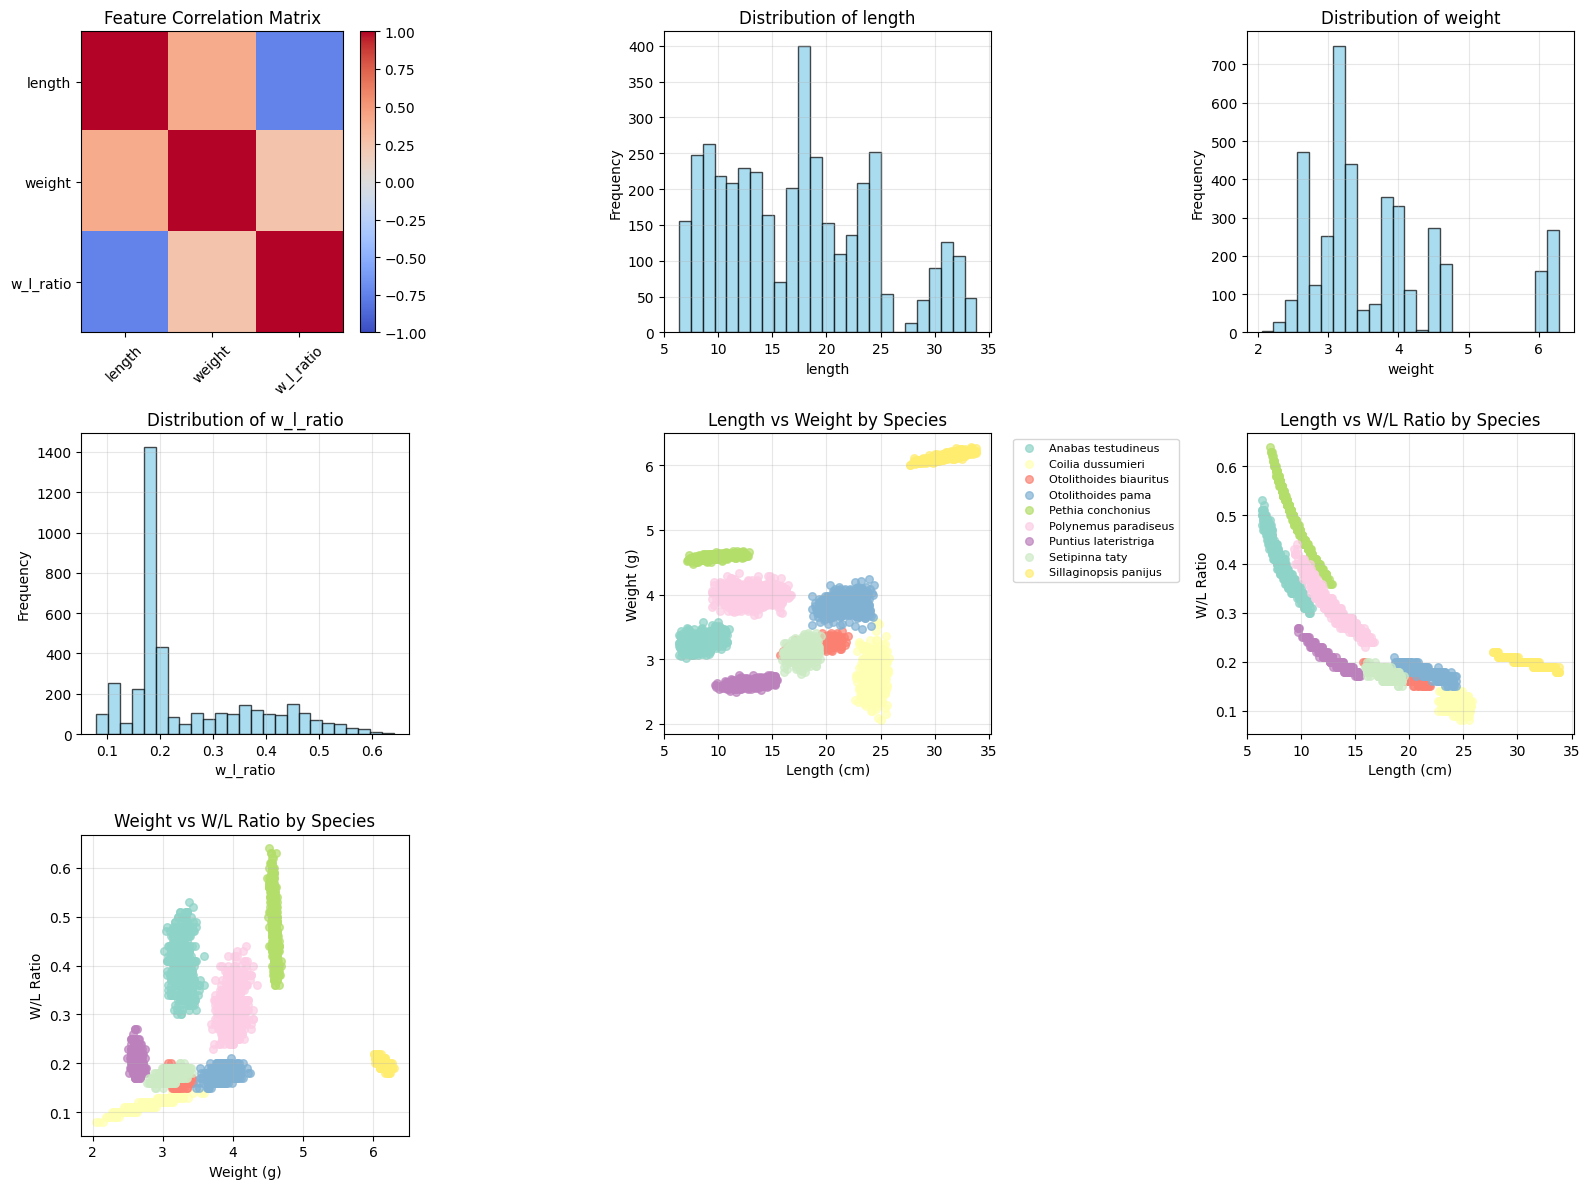

In [100]:
# Visualizations
plt.figure(figsize=(16, 12))

# Correlation heatmap
plt.subplot(3, 3, 1)
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(feature_columns)), feature_columns, rotation=45)
plt.yticks(range(len(feature_columns)), feature_columns)
plt.title('Feature Correlation Matrix')

# Distribution plots
for i, col in enumerate(feature_columns):
    plt.subplot(3, 3, i + 2)
    plt.hist(df[col], bins=25, alpha=0.7, edgecolor='black', color='skyblue')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')
    plt.grid(True, alpha=0.3)


# Species-wise scatter plots
colors = plt.cm.Set3(np.linspace(0, 1, len(df['species'].unique())))
species_list = df['species'].unique()

plt.subplot(3, 3, 5)
for i, species in enumerate(species_list):
    species_data = df[df['species'] == species]
    plt.scatter(species_data['length'], species_data['weight'],
               label=species, alpha=0.7, color=colors[i], s=30)
plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.title('Length vs Weight by Species')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 6)
for i, species in enumerate(species_list):
    species_data = df[df['species'] == species]
    plt.scatter(species_data['length'], species_data['w_l_ratio'],
               label=species, alpha=0.7, color=colors[i], s=30)
plt.xlabel('Length (cm)')
plt.ylabel('W/L Ratio')
plt.title('Length vs W/L Ratio by Species')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 7)
for i, species in enumerate(species_list):
    species_data = df[df['species'] == species]
    plt.scatter(species_data['weight'], species_data['w_l_ratio'],
               label=species, alpha=0.7, color=colors[i], s=30)
plt.xlabel('Weight (g)')
plt.ylabel('W/L Ratio')
plt.title('Weight vs W/L Ratio by Species')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Find Optimal Number of Clusters

Mencari Optimal K untuk Cluster
Testing k =2..
Testing k =3..
Testing k =4..
Testing k =5..
Testing k =6..
Testing k =7..
Testing k =8..


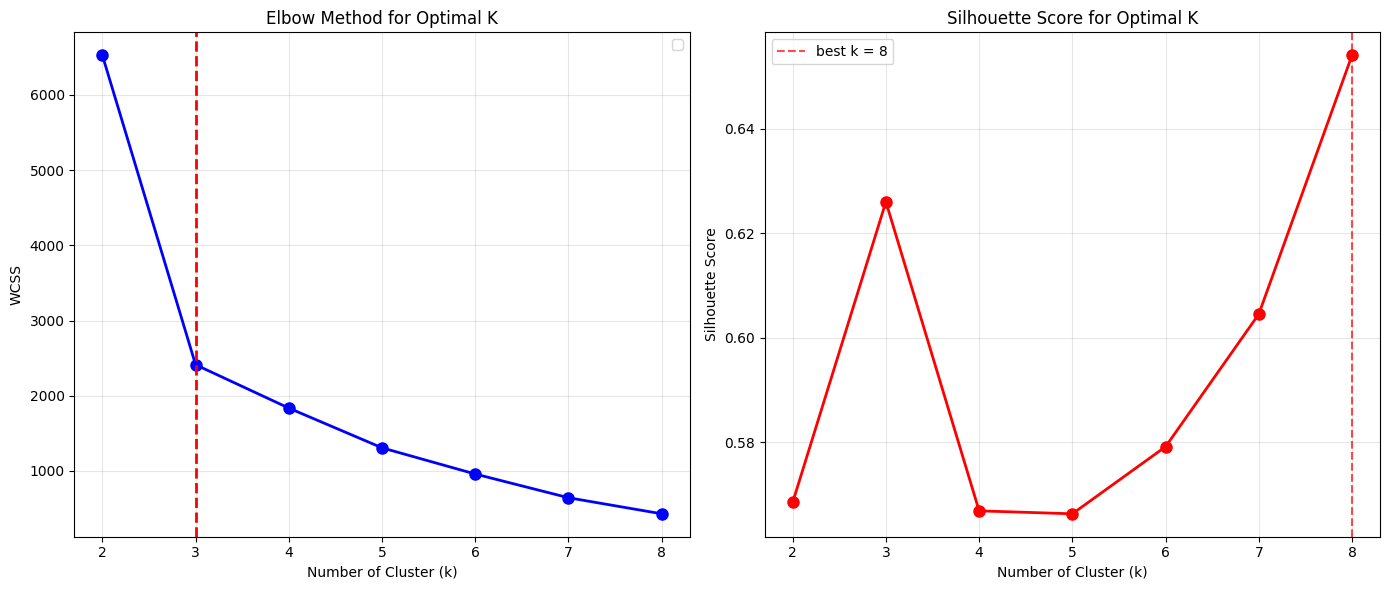


Optimal K based on Silhouette Score : 8
Silhouette scores bt k : {2: np.float64(0.5684638689896863), 3: np.float64(0.6259885197379873), 4: np.float64(0.5668277643365074), 5: np.float64(0.5662647915440117), 6: np.float64(0.5791153302043948), 7: np.float64(0.6044920468034348), 8: np.float64(0.6540450979271023)}


In [81]:
optimal_number = optimal_k(X_scaled, max_k=8)

## Kmeans Clustering

Silhouette Score untuk K=8: 0.5910


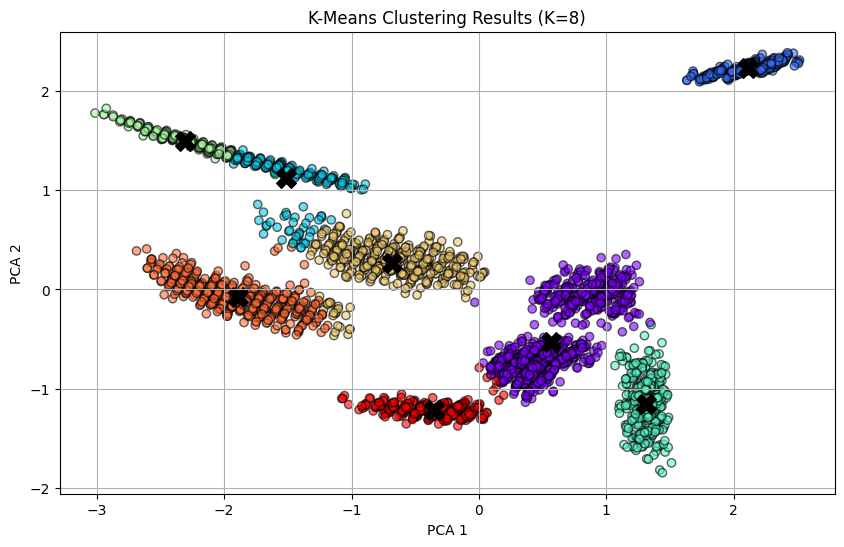

In [101]:
# Jalankan KMeans dengan k optimal (8)
best_k = optimal_number  # dari hasil sebelumnya
kmeans = Kmeans(k=best_k, init='kmeans++')
kmeans.fit(X_scaled)

# Ambil hasil clustering
labels = kmeans.cluster
centroids = kmeans.centroid

# Hitung silhouette score
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score untuk K={best_k}: {sil_score:.4f}")

# Visualisasi hasil clustering
def plot_results(X, cluster, centroid, title, feature_names):
    plt.figure(figsize=(10,6))

    # Jika data berdimensi 2, langsung plot
    if X.shape[1] == 2:
        plt.scatter(X[:,0], X[:,1], c=cluster, cmap='rainbow', alpha=0.6, edgecolor='k')
        plt.scatter(centroid[:,0], centroid[:,1], c='black', s=200, marker='X')
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    else:
        # Jika dimensi >2, gunakan PCA agar bisa divisualisasi
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        centroids_pca = pca.transform(centroid)

        plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster, cmap='rainbow', alpha=0.6, edgecolor='k')
        plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=200, marker='X')
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")

    plt.title(title)
    plt.grid(True)
    plt.show()

# Panggil fungsi visualisasi
plot_results(X_scaled, labels, centroids, f"K-Means Clustering Results (K={best_k})", feature_columns)

In [102]:
# Buat DataFrame gabungan
df_clustered = pd.DataFrame(X_scaled, columns=feature_columns)
df_clustered['Cluster'] = labels

# Statistik per klaster
cluster_summary = df_clustered.groupby('Cluster').mean()
print(cluster_summary)

           length    weight  w_l_ratio
Cluster                               
0        0.283047 -0.345995  -0.630781
1        1.943948  2.343055  -0.439800
2       -0.953041  0.768059   1.439681
3        0.991991 -0.953740  -1.134958
4       -1.244581  0.815140   2.328794
5       -0.599541  0.215408   0.430190
6       -1.311143 -0.443911   1.293152
7       -0.597496 -1.058388  -0.399971
